In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  #解决中文显示乱码问题
plt.rcParams['axes.unicode_minus']=False
import warnings
warnings.filterwarnings(action = 'ignore')
from sklearn.metrics import confusion_matrix,f1_score,roc_curve, auc, precision_recall_curve,accuracy_score,classification_report
from sklearn.model_selection import train_test_split,KFold,LeaveOneOut,LeavePOut # 数据集划分方法
from sklearn.model_selection import cross_val_score,cross_validate # 计算交叉验证下的测试误差
from sklearn import preprocessing
import sklearn.linear_model as LM
from sklearn import neighbors
from sklearn.model_selection import train_test_split#导入划分数据集的模块
from sklearn.neighbors import KNeighborsRegressor #导入knn回归算法
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier



# 1、导入数据

在网上搜集到关于微信文章的数据，数据主题分别为点赞数、转发数、热度指数、文章评级与浏览量。

In [4]:
data = pd.read_excel("C:/Users/MECHREVO/Desktop/机器学习/数据.xlsx")
data

,点赞数,转发数,热度指数,文章评级,浏览量
0,2646,1347.0,7,5,260004
1,816,816.0,4,6,100004
2,1224,612.0,6,5,164502
3,1261,1261.0,6,6,163001
4,1720,1720.0,7,5,260401
...,...,...,...,...,...
994,2031,1153.0,7,5,222504
995,1647,806.0,6,4,128001
996,1632,1240.0,6,6,139004
997,900,900.0,5,7,134801


# 2、数据预处理

In [5]:
data.isna().sum() #查询数据是否存在缺失值，以及个数

点赞数      0
转发数     29
热度指数     0
文章评级     0
浏览量      0
dtype: int64

In [6]:
data = data.dropna() #删除出现缺失值的行

<function matplotlib.pyplot.show(close=None, block=None)>

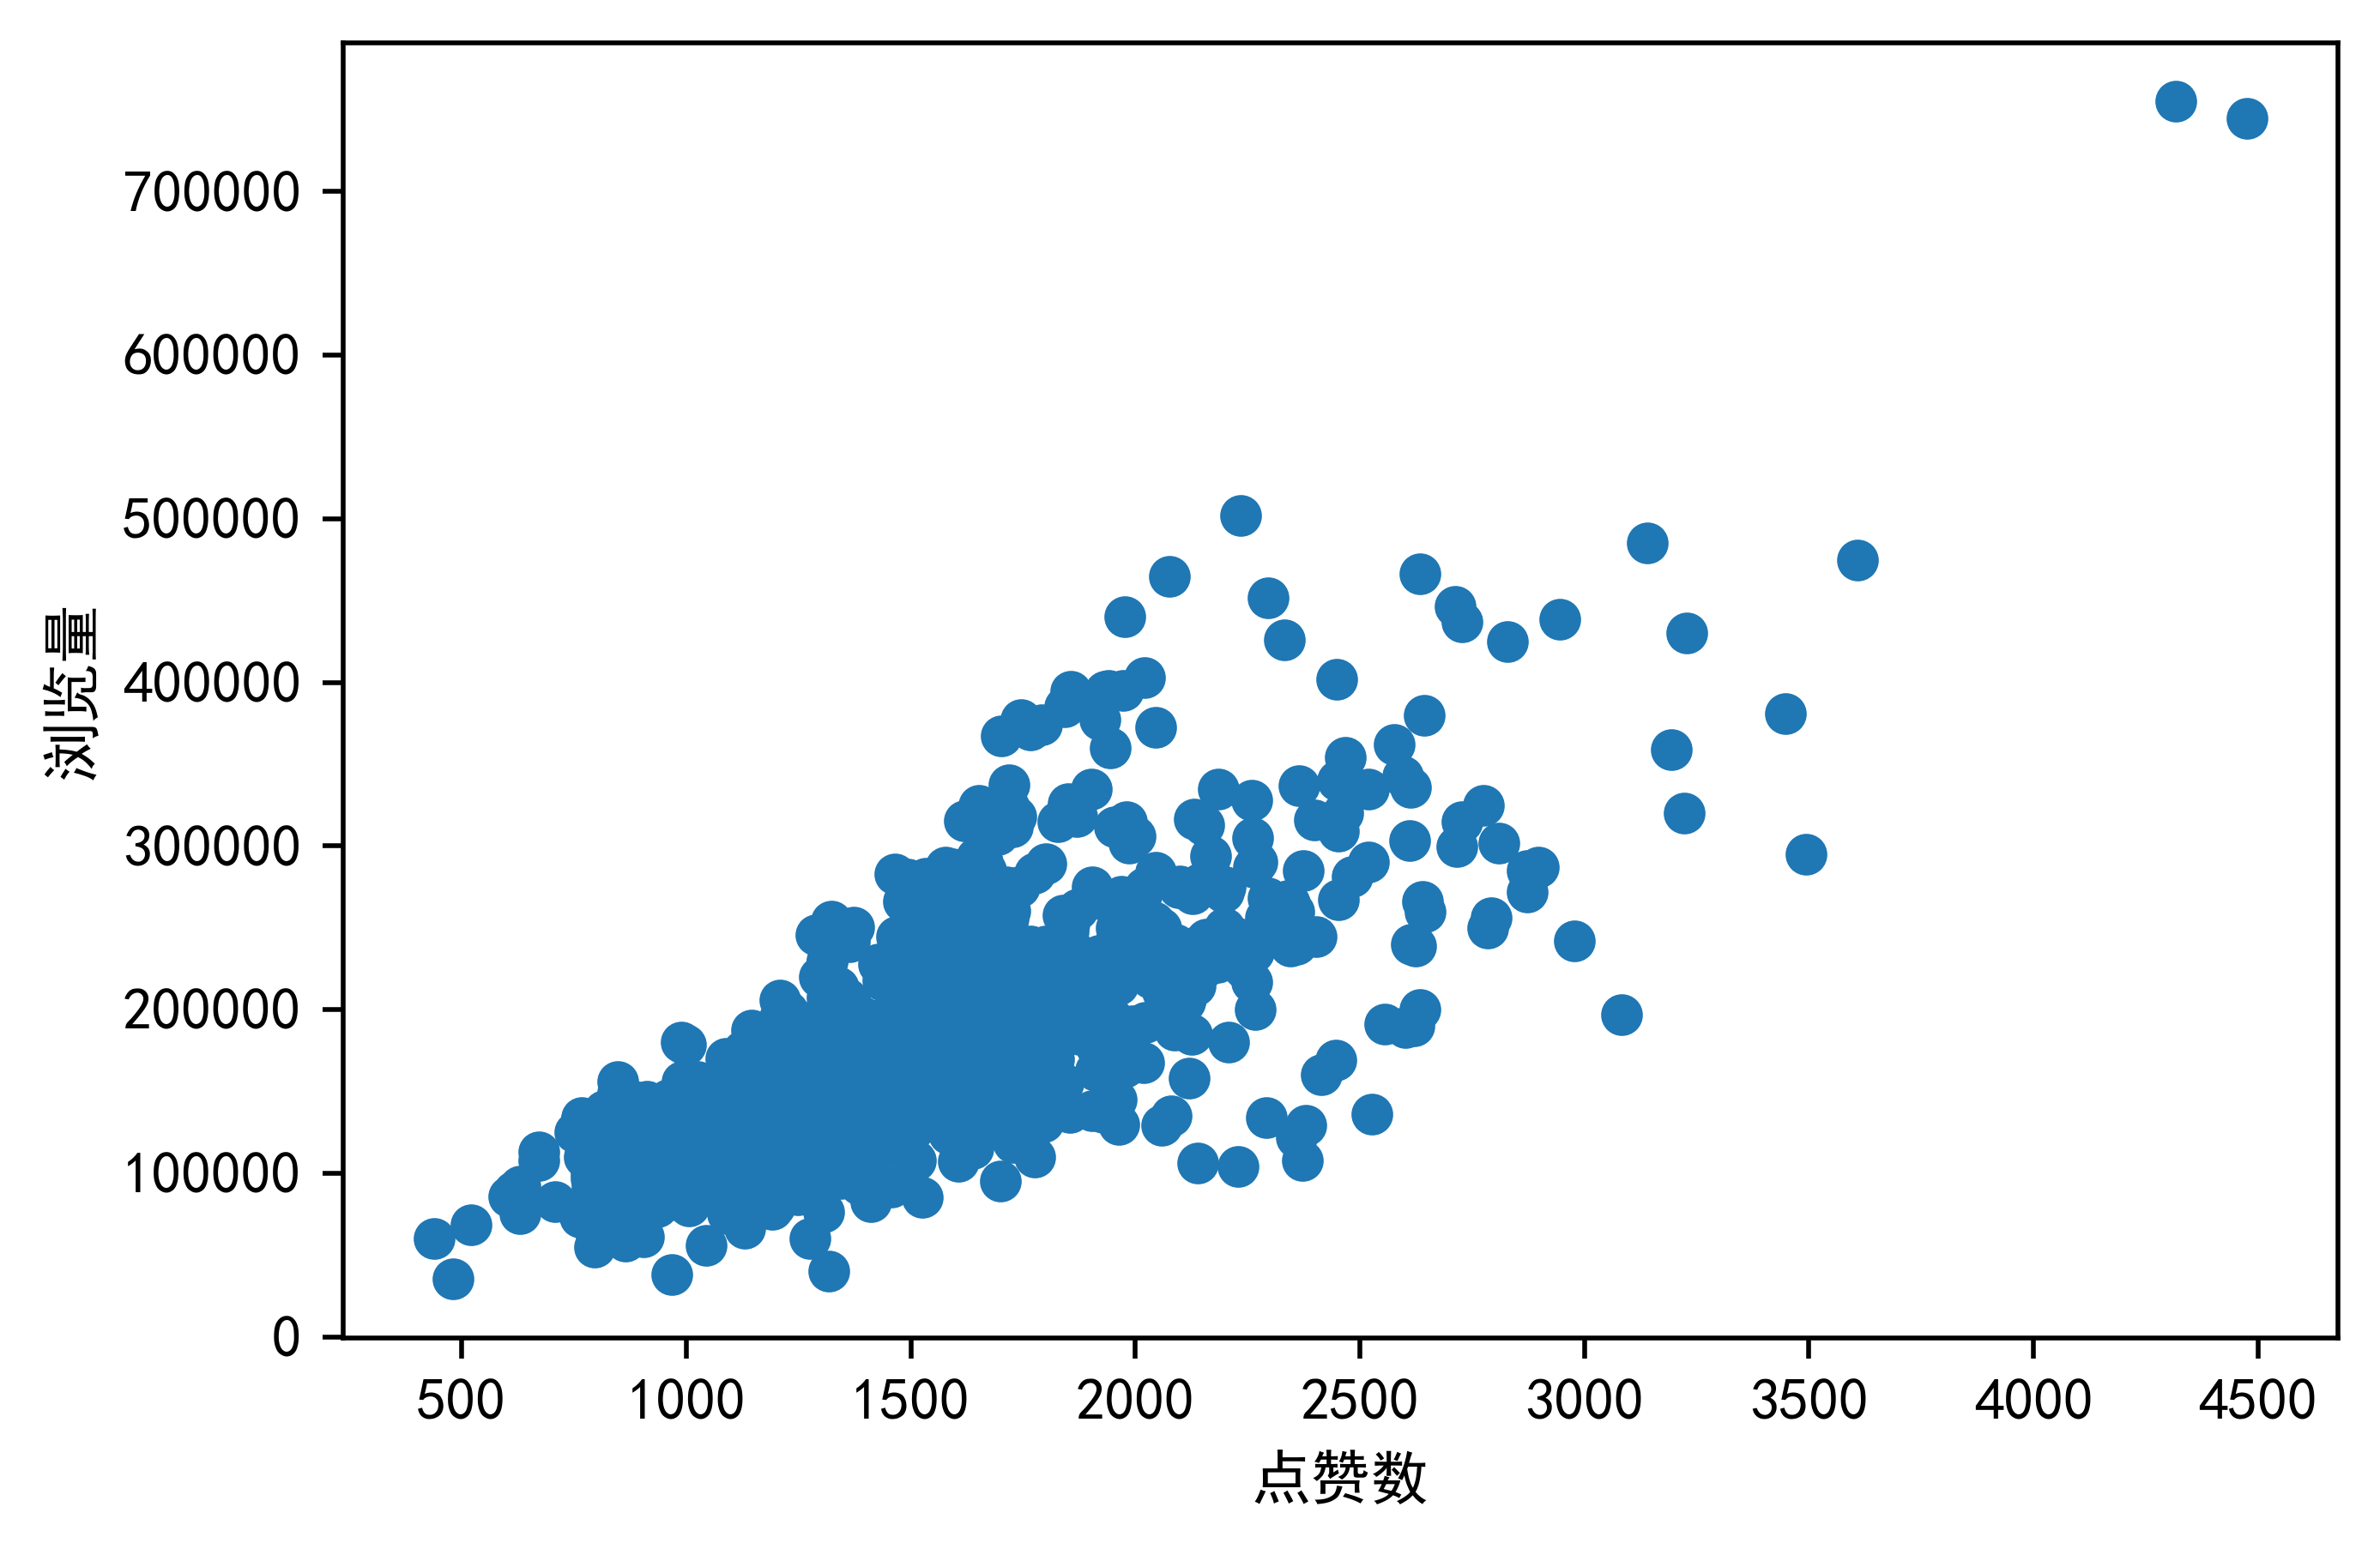

In [7]:
#绘制散点图，观察图形的大致形状
plt.figure(dpi=500)  
plt.scatter(data['点赞数'],data['浏览量'],marker='o') #观察点赞数和浏览量是不是存在某种关系
plt.xlabel('点赞数')
plt.ylabel('浏览量')
plt.show

# 3、多元回归分析

In [8]:
#模型建立
X=data[['点赞数','转发数','热度指数','文章评级']]
y=data['浏览量']
# 将数据集进行分割
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
print(lr.coef_)
print(lr.intercept_)

[   60.97904882    55.98578003 24293.35876805  4222.01400062]
-141657.51840993148


因此，初步建立的多元回归模型为 Y = 60.97904882*X1 + 55.98578003*X2 + 24293.35876805*X3 + 4222.01400062*X4 - 141657.51840993148

In [9]:
#模型评估
y_pred = lr.predict(X_test)
from sklearn import metrics
MSE = metrics.mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
print('MSE',MSE)
print('RMSE',RMSE) #用均方差根评价多元线性回归模型，数值越小说明拟合度越高

MSE 1357285946.1021166
RMSE 36841.3618926081


RMSE的值很大，说明模型拟合度不好。下面先对于训练后的预测值与真实值间进行可视化。

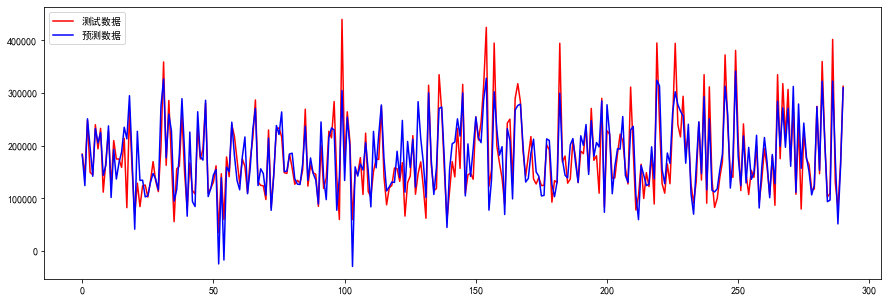

In [10]:
#训练后的预测值与真实值间的可视化
plt.figure(figsize=(15,5))
plt.plot(range(len(y_test)),y_test,'r',label='测试数据')
plt.plot(range(len(y_test)),y_pred,'b',label='预测数据')
plt.legend()

由图可以发现，蓝线和红线在中间部分拟合度较高，但在峰值和谷值经常出现过拟合或低拟合现象，说明模型拟合度不够。下面用散点图更直观的表现拟合不好的情况：

Text(0, 0.5, '预测值')

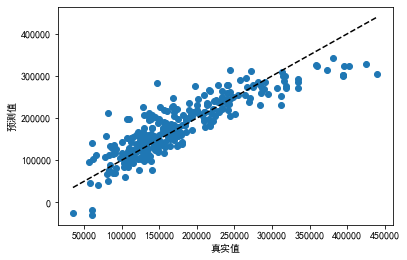

In [11]:
plt.scatter(y_test,y_pred)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'k--')
plt.xlabel('真实值')
plt.ylabel('预测值')

由图可见，在中间部分有些预测值明显高于真实值，而异常值对于拟合的差距影响很大，因此改变参数重新拟合。

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=1)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
print(lr.coef_)
print(lr.intercept_)
y_pred = lr.predict(X_test)
RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
print('RMSE',RMSE)

[   62.17473488    57.12015461 24476.89126847  4577.83348558]
-147551.36945547632
RMSE 34887.89741256551


Text(0, 0.5, '预测值')

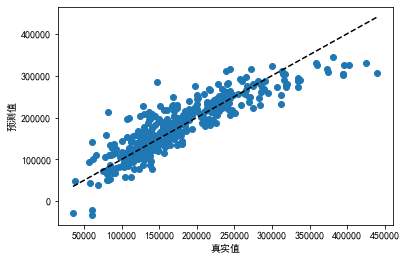

In [15]:
plt.scatter(y_test,y_pred)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'k--')
plt.xlabel('真实值')
plt.ylabel('预测值')

改变完参数后，图像明显更加紧凑，RMSE值也更小，拟合更好一些。此时的回归方程为：
Y = 62.17473488*X1 + 57.12015461*X2 + 24476.89126847*X3 + 4577.83348558*X4 - 147551.36945547632

# 4、K近邻法回归

In [16]:
# 模型建立，以n_neighbors=1为基础
X=data[['点赞数','转发数','热度指数','文章评级']]
y=data['浏览量']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=24)
knn=KNeighborsRegressor(n_neighbors=1)
knn.fit(X_train,y_train)
prediction=knn.predict(X_test)
r2_score(y_test,prediction)

0.47877313481825146

得到的预测准确度为0.48，显然准确度不高，因此我们接下来对所有n_neighbors的可能取值进行讨论，找到最佳参数。

In [17]:
# 找到最合适的n_neighbors值
result={}
for i in range(100): #一般n_neighbors的选取低于样本总数的平方根
    knn=KNeighborsRegressor(n_neighbors=(i+1))
    knn.fit(X_train,y_train)
    prediction=knn.predict(X_test)
    score=r2_score(y_test,prediction)
    result[i+1]=score*100
for i in result.keys():
    if result[i]==max(result.values()):
        print("最佳邻近数："+str(i))
print("模型评分："+str(max(result.values())))

最佳邻近数：11
模型评分：69.07877736814811


当n_neighbors为11时，模型得到最佳效果，评分为0.69。该评分虽然比之前有所进步，但依旧不是很高，说明KNN模型对该组数据的拟合度一般。

# 5、决策树

要使用决策树，我们先得将要预测的结果（即浏览量）划分为几个小类。

In [ ]:
# 对标签进行排序并且做出柱状图
data['热度指数'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('Class distribution for the MNIST Dataset', fontsize=20) 
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.xlabel('Class', fontsize=16)  
plt.ylabel('Frequency', fontsize=16)  


In [18]:
data.iloc[:,4]

0      260004
1      100004
2      164502
3      163001
4      260401
        ...  
994    222504
995    128001
996    139004
997    134801
998     99903
Name: 浏览量, Length: 970, dtype: int64

In [ ]:
X=data.iloc[:,:4]  # 选择所有行和列，但排除列1
print("features shape: ", X.shape)
y=data['浏览量']  # 将label列作为预测值
print("Target shape: ", y.shape)
# 划分数据集
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size = 0.3,random_state=0)
# 将训练集与验证集的尺度进行输出
dtModel = DecisionTreeClassifier()  # 建立模型
dtModel.fit(X_train,y_train)  
prediction = dtModel.predict(X_valid)  
plt.figure(figsize=(10,7)) 
cm = confusion_matrix(y_valid,  prediction) 

ax = sns.heatmap(cm, annot=True, fmt="d",cmap='Blues')  
plt.ylabel('Actual label')  # x轴标题
plt.xlabel('Predicted label')  # y轴标题

acc = accuracy_score(y_valid,prediction)  
print(f"Sum Axis-1 as Classification accuracy: {acc* 100}")

